In [1]:
import time
import numpy as np
import pandas as pd
import hydroeval as he
import json
import matplotlib.pyplot as plt
import sys
from datetime import date
from datetime import datetime, timedelta

sys.path.insert(0, './CFE')
#import bmi_cfe_originial
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI


(750.0, 780.0)

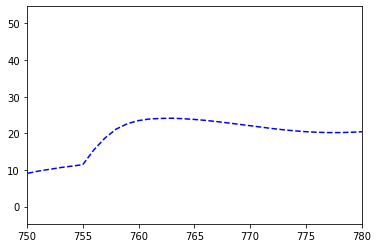

In [2]:
# GET OBSERVATIONS
cfe_obs = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_obs.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
with open(cfe_obs.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
OBSERVATIONS_LIST = []
OBSERVATIONS_LIST_2 = []
for i, precip in enumerate(df_forcing['APCP_surface_0']): #i is RAINRATE
    cfe_obs.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) 
    cfe_obs.update()
    OBSERVATIONS_LIST.append(cfe_obs.get_value('land_surface_water__runoff_depth') + np.sin(i/5) * 2)
    
    
# for i, precip in enumerate(df_forcing['APCP_surface_NoObsEnd']): #i is RAINRATE
#     cfe_obs.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) 
#     cfe_obs.update()
#     OBSERVATIONS_LIST_2.append(cfe_obs.get_value('land_surface_water__runoff_depth') + np.sin(i/5) * 2)   
   
#OBSERVATIONS_LIST_2 = OBSERVATIONS_LIST[0:769] # getting observations for EnKF without 18hour forecast

cfe_obs.finalize()
plt.plot(OBSERVATIONS_LIST_2,color = 'green',)
plt.plot(OBSERVATIONS_LIST,color = 'blue', linestyle='dashed')
plt.xlim(750,780)

In [3]:
## Open BMI's for each file
#cfe_open = bmi_cfe_open.BMI_CFE()
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE() #One BMI to rule them all
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()

In [4]:
# Initialize Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
enkf.initialize(cfg_file='./Assimilation/EnKF_config-synthetic.json') # Need to create this still

initialized 10


In [5]:
#Make empty matrices for plotting
# cfeOpen = []
# cfePeturbed = []
# cfeAnalysis = []
# cfeEnKF = []

n_loop = 2
cfeOpen_ensa=[]
cfeAnalysis_ens=[]
## Loop through 100 different precipitation files for forcing 
for loop in range(n_loop):
    p = 'APCP_surface_' + str(loop)
    
    cfeOpen = []
    cfePeturbed = []
    cfeAnalysis = []
    cfeEnKF = []
    
    # Initialize Case study files
    cfe_open.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    cfe_analysis.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    enkf.initialize(cfg_file='./Assimilation/EnKF_config-synthetic.json') # Need to create this still
    
    ## Loop through time. Set values for each model and get values
    for i, precip in enumerate(df_forcing[str(p)]): #i is RAINRATE

        # Set values for each model
        cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3) #value of precip from forcing data in loop
        cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)
        cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)

        obs = OBSERVATIONS_LIST[i]
        enkf.set_value('validity', 1)

        if i>769:
            enkf.set_value('validity', 0)

        # Update CFE open and peturbed. Get value for peturbed stats. 
        cfe_open.update()
        cfe_peturbed.update()

        # Get state vars from Peturbed. These are values as enkf uses
        soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
        soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
        surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')

        # Get values for plotting
        outflow = cfe_open.get_value('land_surface_water__runoff_depth')
        cfeOpen.append(outflow) #for plotting
        outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')

        # Get mean and covariance for stats of ensemble runs for EnKF
        outflow_peturb_mean = np.mean(outflow_peturb)
        outflow_peturb_covar = np.cov(outflow_peturb)
        cfePeturbed.append(outflow_peturb_mean) # For plotting

        # Set EnKF value to usgs, mean, and covariance. Get value from it then update
        enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
        enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
        enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf

        enkf.set_value('x', np.array([outflow_peturb_mean]))
        enkf.set_value('P', np.array([outflow_peturb_covar]))
        enkf.set_value('z', np.array([obs]))
        enkf.update()

        # For plotting
        outflow_enkf = enkf.get_value('enkf')
        cfeEnKF.append(outflow_enkf)

        # Get new EnKF state vars to give back to CFE Analysis
        state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
        state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
        state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')

        # Set value for CFE analysis based on the state variable change from the EnKF factor to get true streamflow
        cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage)    
        cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res)  
        cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
        cfe_analysis.update() #get new streamflow value based on state var change

        # For plotting
        outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
        cfeAnalysis.append(outflow_analysis) 

        # Get values from new CFE analysis to put back into CFE Peturbed to keep look and EnKF going
        cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
        cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
        cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')

        # Set value from CFE analysis state variables back into CFE Peturbed to continue EnKF loop
        cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
        cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
        cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)
    
    # predicted values
    cfeOpen_error=cfe_open#.subtract(OBSERVATIONS_LIST[769:])
    cfeAnalysis_error=cfeAnalysis#[769:]#.subtract(OBSERVATIONS_LIST[769:])
    # reaults of 100
    cfeOpen_ensa.append(np.divide(np.subtract(cfeOpen,OBSERVATIONS_LIST),OBSERVATIONS_LIST))
    cfeAnalysis_ens.append(np.divide(np.subtract(cfeAnalysis,OBSERVATIONS_LIST),OBSERVATIONS_LIST))
    
    # mean of 100
    # print("open",cfeOpen)
    # print("obs2",OBSERVATIONS_LIST)
    # print("analysis-obs",cfeAnalysis_ens)
    cfeOpen_ensa_mean=np.mean(cfeOpen_ensa,axis=0)
    cfeanalys_ensa_mean=np.mean(cfeAnalysis_ens,axis=0)
    # Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
enkf.finalize()



initialized 10
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3121136221931379
EnKF Code predicted, X Post [9.17041203]
surface_runoff_ratio [2.16166509]
Leftover vol 0.0
surface _runoff [2.16166509]
***********over estimaiton ratio [1.]
Observation BMI [9.14803171]
CFE [26.19995495]
enkf [9.17041203]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2957114578598735
EnKF Code predicted, X Post [16.76221047]
surface_runoff_ratio [1.52581843]
Leftover vol [25.69501139]
surface _runoff [1.52581843]
***********over estimaiton ratio [0.39480234]
Observation BMI [16.75252741]
CFE [42.45722186]
enkf [16.76221047]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.28072802840953426
EnKF Code predicted, X Post [22.31920363]
surface_runoff_ratio [1.78193948]
Leftover vol [25.29137077]
surface _runoff [1.78193948]
***********over estimaiton ratio [0.46878669]
Observation BMI [22.40183725]
CFE [47.61057

EnKF Code predicted, X Post [0.61049505]
***********under estimaiton ratio [109.55240139]
Observation BMI [2.00477374]
CFE [0.00557263]
enkf [0.61049505]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.26145073659930274
EnKF Code predicted, X Post [0.99048119]
***********under estimaiton ratio [146.67141873]
Observation BMI [1.98660555]
CFE [0.00675306]
enkf [0.99048119]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2678111078250397
EnKF Code predicted, X Post [1.09685737]
***********under estimaiton ratio [206.95943241]
Observation BMI [1.88954848]
CFE [0.00529987]
enkf [1.09685737]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.27406809443034597
EnKF Code predicted, X Post [1.42258147]
***********under estimaiton ratio [154.19100378]
Observation BMI [1.7174796]
CFE [0.0092261]
enkf [1.42258147]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.280223376

surface _runoff [3.05773351]
***********over estimaiton ratio [1.]
Observation BMI [4.30511966]
CFE [26.72200161]
enkf [3.70287541]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.27880870605189123
EnKF Code predicted, X Post [5.53507096]
surface_runoff_ratio [2.66767487]
Leftover vol 0.0
surface _runoff [2.66767487]
***********over estimaiton ratio [1.]
Observation BMI [5.66870066]
CFE [26.17557309]
enkf [5.53507096]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2653393321066322
EnKF Code predicted, X Post [7.27554386]
surface_runoff_ratio [0.48723816]
Leftover vol [23.63062821]
surface _runoff [0.48723816]
***********over estimaiton ratio [0.23540747]
Observation BMI [6.53878443]
CFE [30.90617207]
enkf [7.27554386]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.25303027251856347
EnKF Code predicted, X Post [7.68896442]
surface_runoff_ratio [1.39914603]
Leftover vol 0.0
surface _runof

EnKF Code predicted, X Post [-0.22844594]
surface_runoff_ratio [0.0562572]
Leftover vol 0.0
surface _runoff [0.0562572]
***********over estimaiton ratio [1.]
Observation BMI [-0.35894278]
CFE [0.63116875]
enkf [-0.22844594]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1841053072091946
EnKF Code predicted, X Post [0.0743624]
surface_runoff_ratio [0.01700192]
Leftover vol 0.0
surface _runoff [0.01700192]
***********over estimaiton ratio [1.]
Observation BMI [-0.13609577]
CFE [0.21827592]
enkf [0.0743624]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1917228893076539
EnKF Code predicted, X Post [-0.09919904]
surface_runoff_ratio [0.01451707]
Leftover vol 0.0
surface _runoff [0.01451707]
***********over estimaiton ratio [1.]
Observation BMI [0.20782817]
CFE [0.19763608]
enkf [-0.09919904]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19921665145820477
EnKF Code predicted, X Post [0.720

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.14820585302517586
EnKF Code predicted, X Post [10.7691769]
surface_runoff_ratio [1.33998358]
Leftover vol 0.0
surface _runoff [1.33998358]
***********over estimaiton ratio [1.]
Observation BMI [10.27703293]
CFE [14.67858881]
enkf [10.7691769]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.14599381439175407
EnKF Code predicted, X Post [10.61358006]
surface_runoff_ratio [1.53588273]
Leftover vol 0.0
surface _runoff [1.53588273]
***********over estimaiton ratio [1.]
Observation BMI [10.15451259]
CFE [20.29162056]
enkf [10.61358006]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.14397297215185223
EnKF Code predicted, X Post [7.54943924]
surface_runoff_ratio [1.02178248]
Leftover vol 0.0
surface _runoff [1.02178248]
***********over estimaiton ratio [1.]
Observation BMI [7.21836014]
CFE [8.92010692]
enkf [7.54943924]
Beginning-------------------

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19156880218352768
EnKF Code predicted, X Post [0.2933899]
***********under estimaiton ratio [2.04168421]
Observation BMI [0.94210142]
CFE [0.14369994]
enkf [0.2933899]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19906506894242215
EnKF Code predicted, X Post [0.56300202]
***********under estimaiton ratio [21.44046872]
Observation BMI [1.17830522]
CFE [0.02625885]
enkf [0.56300202]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.20643948767295328
EnKF Code predicted, X Post [0.15067578]
***********under estimaiton ratio [6.5214493]
Observation BMI [1.47914986]
CFE [0.02310465]
enkf [0.15067578]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.21369403895325312
EnKF Code predicted, X Post [0.37495813]
***********under estimaiton ratio [15.4463753]
Observation BMI [1.72182081]
CFE [0.02427483]
enkf [0.37495813

EnKF Code predicted, X Post [-0.26473771]
surface_runoff_ratio [0.00158776]
Leftover vol 0.0
surface _runoff [0.00158776]
***********over estimaiton ratio [1.]
Observation BMI [-0.66312295]
CFE [0.01019999]
enkf [-0.26473771]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.27387811105530147
EnKF Code predicted, X Post [0.10045647]
***********under estimaiton ratio [3.40856992]
Observation BMI [-0.27607993]
CFE [0.02947173]
enkf [0.10045647]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.280036481588707
EnKF Code predicted, X Post [0.04754062]
***********under estimaiton ratio [2.34985759]
Observation BMI [0.12277042]
CFE [0.02023128]
enkf [0.04754062]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.28609475092086634
EnKF Code predicted, X Post [0.09843128]
***********under estimaiton ratio [4.61325905]
Observation BMI [0.51752671]
CFE [0.0213366]
enkf [0.09843128]
Beginning--------------

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.24150873127989247
EnKF Code predicted, X Post [0.98121398]
***********under estimaiton ratio [42.09057283]
Observation BMI [1.67386318]
CFE [0.02331197]
enkf [0.98121398]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.248193249725564
EnKF Code predicted, X Post [0.46420961]
***********under estimaiton ratio [24.9080134]
Observation BMI [1.41741788]
CFE [0.01863696]
enkf [0.46420961]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.25476911470153374
EnKF Code predicted, X Post [0.45822521]
***********under estimaiton ratio [20.61024067]
Observation BMI [1.10526769]
CFE [0.02223289]
enkf [0.45822521]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.26123809231505
EnKF Code predicted, X Post [0.47011973]
***********under estimaiton ratio [22.31692682]
Observation BMI [0.74985694]
CFE [0.02106561]
enkf [0.47011973

EnKF Code predicted, X Post [-0.36747109]
surface_runoff_ratio [0.0257026]
Leftover vol 0.0
surface _runoff [0.0257026]
***********over estimaiton ratio [1.]
Observation BMI [-1.4047854]
CFE [0.32465535]
enkf [-0.36747109]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19900387286660348
EnKF Code predicted, X Post [-0.92036362]
surface_runoff_ratio [0.00158639]
Leftover vol 0.0
surface _runoff [0.00158639]
***********over estimaiton ratio [1.]
Observation BMI [-1.79991324]
CFE [0.02331135]
enkf [-0.92036362]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.20637928630842517
EnKF Code predicted, X Post [-0.04714679]
surface_runoff_ratio [0.00158755]
Leftover vol 0.0
surface _runoff [0.00158755]
***********over estimaiton ratio [1.]
Observation BMI [-1.92832736]
CFE [0.02157348]
enkf [-0.04714679]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.21363481613148616
EnKF Code predicted, X Post 

***********over estimaiton ratio [1.]
Observation BMI [14.72648223]
CFE [20.03711903]
enkf [14.90098774]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.15210958201837166
EnKF Code predicted, X Post [9.59418414]
surface_runoff_ratio [1.17263585]
Leftover vol 0.0
surface _runoff [1.17263585]
***********over estimaiton ratio [1.]
Observation BMI [9.35571829]
CFE [15.69430031]
enkf [9.59418414]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16024723846262912
EnKF Code predicted, X Post [5.94257012]
surface_runoff_ratio [0.62097205]
Leftover vol 0.0
surface _runoff [0.62097205]
***********over estimaiton ratio [1.]
Observation BMI [5.52895566]
CFE [8.07598864]
enkf [5.94257012]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16825262141327646
EnKF Code predicted, X Post [3.88891547]
surface_runoff_ratio [0.31206937]
Leftover vol 0.0
surface _runoff [0.31206937]
***********over estimaiton rat

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.21310156828021443
EnKF Code predicted, X Post [25.48327981]
surface_runoff_ratio [1.78637818]
Leftover vol [34.421502]
surface _runoff [1.78637818]
***********over estimaiton ratio [0.42539642]
Observation BMI [25.04564952]
CFE [59.90478181]
enkf [25.48327981]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.20526584456826769
EnKF Code predicted, X Post [25.42577991]
surface_runoff_ratio [3.70537995]
Leftover vol 0.0
surface _runoff [3.70537995]
***********over estimaiton ratio [1.]
Observation BMI [25.44310879]
CFE [39.26928185]
enkf [25.42577991]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1981080734350118
EnKF Code predicted, X Post [24.95855287]
surface_runoff_ratio [2.55100585]
Leftover vol [18.48539961]
surface _runoff [2.55100585]
***********over estimaiton ratio [0.57450005]
Observation BMI [25.82181884]
CFE [43.44395248]
enkf [24

EnKF Code predicted, X Post [-0.36624861]
surface_runoff_ratio [0.00158979]
Leftover vol 0.0
surface _runoff [0.00158979]
***********over estimaiton ratio [1.]
Observation BMI [-1.71242916]
CFE [0.02047986]
enkf [-0.36624861]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2277774124731019
EnKF Code predicted, X Post [-0.89791563]
surface_runoff_ratio [0.0015905]
Leftover vol 0.0
surface _runoff [0.0015905]
***********over estimaiton ratio [1.]
Observation BMI [-1.4794138]
CFE [0.01800291]
enkf [-0.89791563]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2346851265676546
EnKF Code predicted, X Post [-0.35312207]
surface_runoff_ratio [0.00159103]
Leftover vol 0.0
surface _runoff [0.00159103]
***********over estimaiton ratio [1.]
Observation BMI [-1.18661528]
CFE [0.02193337]
enkf [-0.35312207]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.24148055926001177
EnKF Code predicted, X Post [-

CFE [80.35481601]
enkf [51.61550188]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2440708803788766
EnKF Code predicted, X Post [51.86149488]
surface_runoff_ratio [4.81119291]
Leftover vol [22.14615137]
surface _runoff [4.81119291]
***********over estimaiton ratio [0.7007586]
Observation BMI [51.49376147]
CFE [74.00764625]
enkf [51.86149488]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.23355034892494508
EnKF Code predicted, X Post [51.12103349]
surface_runoff_ratio [4.51794307]
Leftover vol [32.80513959]
surface _runoff [4.51794307]
***********over estimaiton ratio [0.60911908]
Observation BMI [51.72219146]
CFE [83.92617308]
enkf [51.12103349]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.22394041305493417
EnKF Code predicted, X Post [51.89803459]
surface_runoff_ratio [3.56054383]
Leftover vol [56.42394539]
surface _runoff [3.56054383]
***********over estimaiton ratio [0.47910899]


Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.262528629309276
EnKF Code predicted, X Post [-0.05691884]
surface_runoff_ratio [0.00146506]
Leftover vol 0.0
surface _runoff [0.00146506]
***********over estimaiton ratio [1.]
Observation BMI [1.1244351]
CFE [0.01915901]
enkf [-0.05691884]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2688714799336628
EnKF Code predicted, X Post [0.90412936]
***********under estimaiton ratio [39.89517736]
Observation BMI [1.43347785]
CFE [0.02266262]
enkf [0.90412936]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.27511123072614074
EnKF Code predicted, X Post [0.89402084]
***********under estimaiton ratio [41.31040348]
Observation BMI [1.68611276]
CFE [0.02164154]
enkf [0.89402084]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2812495575223821
EnKF Code predicted, X Post [0.34581813]
***********under estimaiton ratio [19

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.44681092002554745
EnKF Code predicted, X Post [0.37188646]
***********under estimaiton ratio [21.02863028]
Observation BMI [1.74065718]
CFE [0.01768477]
enkf [0.37188646]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.45015835513067787
EnKF Code predicted, X Post [0.97509417]
***********under estimaiton ratio [72.71835251]
Observation BMI [1.5046984]
CFE [0.01340919]
enkf [0.97509417]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.453451379369606
EnKF Code predicted, X Post [0.40716307]
***********under estimaiton ratio [16.58305775]
Observation BMI [1.20942178]
CFE [0.02455295]
enkf [0.40716307]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.4566908771634686
EnKF Code predicted, X Post [0.51471395]
***********under estimaiton ratio [36.50839879]
Observation BMI [0.86659543]
CFE [0.01409851]
enkf [0.514713

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.22706128112829793
EnKF Code predicted, X Post [-0.15592504]
surface_runoff_ratio [0.01496979]
Leftover vol 0.0
surface _runoff [0.01496979]
***********over estimaiton ratio [1.]
Observation BMI [-1.38555648]
CFE [0.19822581]
enkf [-0.15592504]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.233980635576005
EnKF Code predicted, X Post [-0.73663303]
surface_runoff_ratio [0.00116034]
Leftover vol 0.0
surface _runoff [0.00116034]
***********over estimaiton ratio [1.]
Observation BMI [-1.7471757]
CFE [0.01357662]
enkf [-0.73663303]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.24078751941345788
EnKF Code predicted, X Post [-1.42685151]
surface_runoff_ratio [0.00116302]
Leftover vol 0.0
surface _runoff [0.00116302]
***********over estimaiton ratio [1.]
Observation BMI [-1.90003801]
CFE [0.01309324]
enkf [-1.42685151]
Beginning-------------------

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19595574301164664
EnKF Code predicted, X Post [-0.3044795]
surface_runoff_ratio [0.0955401]
Leftover vol 0.0
surface _runoff [0.0955401]
***********over estimaiton ratio [1.]
Observation BMI [-0.82940173]
CFE [0.89281218]
enkf [-0.3044795]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.20338070226406557
EnKF Code predicted, X Post [-0.45810879]
surface_runoff_ratio [0.02985662]
Leftover vol 0.0
surface _runoff [0.02985662]
***********over estimaiton ratio [1.]
Observation BMI [-1.51133101]
CFE [0.3934431]
enkf [-0.45810879]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2106849725556077
EnKF Code predicted, X Post [-0.55716805]
surface_runoff_ratio [0.01447582]
Leftover vol 0.0
surface _runoff [0.01447582]
***********over estimaiton ratio [1.]
Observation BMI [-1.7864482]
CFE [0.17540516]
enkf [-0.55716805]
Beginning-----------------------

EnKF Code predicted, X Post [-0.50405375]
surface_runoff_ratio [0.00132568]
Leftover vol 0.0
surface _runoff [0.00132568]
***********over estimaiton ratio [1.]
Observation BMI [-1.86818815]
CFE [0.01521752]
enkf [-0.50405375]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.40364478255279757
EnKF Code predicted, X Post [-1.07377393]
surface_runoff_ratio [0.00132254]
Leftover vol 0.0
surface _runoff [0.00132254]
***********over estimaiton ratio [1.]
Observation BMI [-1.69787603]
CFE [0.01755002]
enkf [-1.07377393]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.4076938614110507
EnKF Code predicted, X Post [-0.53765315]
surface_runoff_ratio [0.00131918]
Leftover vol 0.0
surface _runoff [0.00131918]
***********over estimaiton ratio [1.]
Observation BMI [-1.45920811]
CFE [0.02274562]
enkf [-0.53765315]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.4116771245384294
EnKF Code predicted, X Post

Observation BMI [0.5793212]
CFE [0.01376472]
enkf [0.467024]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5212848739686137
EnKF Code predicted, X Post [0.188806]
***********under estimaiton ratio [14.84098169]
Observation BMI [0.94905316]
CFE [0.01272194]
enkf [0.188806]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5234217725834803
EnKF Code predicted, X Post [0.27931442]
***********under estimaiton ratio [19.39807233]
Observation BMI [1.28148948]
CFE [0.01439908]
enkf [0.27931442]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5255239369911198
EnKF Code predicted, X Post [1.10239127]
***********under estimaiton ratio [92.79341551]
Observation BMI [1.56337268]
CFE [0.01188006]
enkf [1.10239127]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5275919317785196
EnKF Code predicted, X Post [0.97508025]
***********under estimaiton ratio [73.16417492]
Obs

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1393940769060268
EnKF Code predicted, X Post [21.07234481]
 warning validity is zero
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.13793693488211278
EnKF Code predicted, X Post [21.49146512]
 warning validity is zero
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.13660589469151263
EnKF Code predicted, X Post [21.47337698]
 warning validity is zero
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.13539004419243106
EnKF Code predicted, X Post [22.09333148]
 warning validity is zero
initialized 10
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3121136221931379
EnKF Code predicted, X Post [9.49530901]
surface_runoff_ratio [2.70511819]
Leftover vol 0.0
surface _runoff [2.70511819]
***********over estimaiton ratio [1.]
Observation BMI [9.14803171]
CFE [28.29444707]
enkf [9.495309

surface _runoff [0.64021611]
***********over estimaiton ratio [1.]
Observation BMI [0.05874039]
CFE [9.39776155]
enkf [1.71986023]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1250708857306817
EnKF Code predicted, X Post [1.65597693]
surface_runoff_ratio [0.10294571]
Leftover vol [12.71258529]
surface _runoff [0.10294571]
***********over estimaiton ratio [0.11525001]
Observation BMI [0.55751944]
CFE [14.36856222]
enkf [1.65597693]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12486137278105491
EnKF Code predicted, X Post [0.70183719]
surface_runoff_ratio [0.61919906]
Leftover vol 0.0
surface _runoff [0.61919906]
***********over estimaiton ratio [1.]
Observation BMI [0.88095149]
CFE [7.08129543]
enkf [0.70183719]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12468238077268112
EnKF Code predicted, X Post [1.76677825]
surface_runoff_ratio [0.79370527]
Leftover vol 0.0
surface _runoff 

surface_runoff_ratio [0.60919704]
Leftover vol [15.17873879]
surface _runoff [0.60919704]
***********over estimaiton ratio [0.32891462]
Observation BMI [7.4676054]
CFE [22.61819335]
enkf [7.43945456]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12299088365296373
EnKF Code predicted, X Post [7.93656165]
surface_runoff_ratio [0.5111398]
Leftover vol [18.76602863]
surface _runoff [0.5111398]
***********over estimaiton ratio [0.29722067]
Observation BMI [7.49292225]
CFE [26.70259028]
enkf [7.93656165]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12295399634201143
EnKF Code predicted, X Post [7.78189946]
surface_runoff_ratio [1.46631327]
Leftover vol 0.0
surface _runoff [1.46631327]
***********over estimaiton ratio [1.]
Observation BMI [7.3846982]
CFE [15.66558993]
enkf [7.78189946]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12292065898034232
EnKF Code predicted, X Post [7.00656719]

EnKF Code predicted, X Post [10.23958563]
surface_runoff_ratio [0.6361947]
Leftover vol [28.276207]
surface _runoff [0.6361947]
***********over estimaiton ratio [0.26585421]
Observation BMI [10.27703293]
CFE [38.51579263]
enkf [10.23958563]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12258518609232838
EnKF Code predicted, X Post [10.58581618]
surface_runoff_ratio [0.57999943]
Leftover vol [24.18905941]
surface _runoff [0.57999943]
***********over estimaiton ratio [0.30440989]
Observation BMI [10.15451259]
CFE [34.77487558]
enkf [10.58581618]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12258471285006756
EnKF Code predicted, X Post [7.45921062]
surface_runoff_ratio [0.52113591]
Leftover vol [11.17025984]
surface _runoff [0.52113591]
***********over estimaiton ratio [0.40039842]
Observation BMI [7.21836014]
CFE [18.62947046]
enkf [7.45921062]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from

surface _runoff [0.89285031]
***********over estimaiton ratio [1.]
Observation BMI [1.99665049]
CFE [11.78272755]
enkf [2.51935071]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1227113830258787
EnKF Code predicted, X Post [2.43696588]
surface_runoff_ratio [0.21417755]
Leftover vol [11.82665841]
surface _runoff [0.21417755]
***********over estimaiton ratio [0.1708518]
Observation BMI [2.01785347]
CFE [14.26362429]
enkf [2.43696588]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12270282370129737
EnKF Code predicted, X Post [1.91017891]
surface_runoff_ratio [0.12563113]
Leftover vol [11.67272805]
surface _runoff [0.12563113]
***********over estimaiton ratio [0.14063108]
Observation BMI [1.95940802]
CFE [13.58290695]
enkf [1.91017891]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12273174600063685
EnKF Code predicted, X Post [2.03410269]
surface_runoff_ratio [0.70402494]
Leftover vol 0

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12285320571338365
EnKF Code predicted, X Post [18.23997156]
surface_runoff_ratio [1.47918852]
Leftover vol [16.35808617]
surface _runoff [1.47918852]
***********over estimaiton ratio [0.5271964]
Observation BMI [18.076595]
CFE [34.59805773]
enkf [18.23997156]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12282708579359036
EnKF Code predicted, X Post [17.8371841]
surface_runoff_ratio [1.27608449]
Leftover vol [18.02944521]
surface _runoff [1.27608449]
***********over estimaiton ratio [0.49731978]
Observation BMI [18.02587883]
CFE [35.86662931]
enkf [17.8371841]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1228046591690064
EnKF Code predicted, X Post [17.96871017]
surface_runoff_ratio [1.28197186]
Leftover vol [22.82593859]
surface _runoff [1.28197186]
***********over estimaiton ratio [0.44046733]
Observation BMI [17.91302936]
CFE [40.794

EnKF Code predicted, X Post [21.87509282]
surface_runoff_ratio [3.21848705]
Leftover vol 0.0
surface _runoff [3.21848705]
***********over estimaiton ratio [1.]
Observation BMI [21.17444522]
CFE [28.45268608]
enkf [21.87509282]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12256848741098358
EnKF Code predicted, X Post [21.56396901]
surface_runoff_ratio [1.95308773]
Leftover vol [29.11563264]
surface _runoff [1.95308773]
***********over estimaiton ratio [0.42549602]
Observation BMI [20.94494128]
CFE [50.67960165]
enkf [21.56396901]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12256655255000104
EnKF Code predicted, X Post [20.77701778]
surface_runoff_ratio [2.41042838]
Leftover vol [17.15192579]
surface _runoff [2.41042838]
***********over estimaiton ratio [0.54778794]
Observation BMI [20.65513704]
CFE [37.92894357]
enkf [20.77701778]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1225

Leftover vol 0.0
surface _runoff [0.98141243]
***********over estimaiton ratio [1.]
Observation BMI [1.90045428]
CFE [11.50860088]
enkf [1.87694352]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12260248622784475
EnKF Code predicted, X Post [3.29967705]
surface_runoff_ratio [0.71166039]
Leftover vol 0.0
surface _runoff [0.71166039]
***********over estimaiton ratio [1.]
Observation BMI [1.72756038]
CFE [6.43967323]
enkf [3.29967705]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12265307028103378
EnKF Code predicted, X Post [0.91899787]
surface_runoff_ratio [0.07158273]
Leftover vol [11.63238886]
surface _runoff [0.07158273]
***********over estimaiton ratio [0.07321883]
Observation BMI [1.48659762]
CFE [12.55138672]
enkf [0.91899787]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12265141928820023
EnKF Code predicted, X Post [1.23273582]
surface_runoff_ratio [0.76454295]
Leftover vol 0

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12263745973692874
EnKF Code predicted, X Post [2.7773469]
surface_runoff_ratio [0.18132809]
Leftover vol [23.73503305]
surface _runoff [0.18132809]
***********over estimaiton ratio [0.1047566]
Observation BMI [2.01977568]
CFE [26.51237994]
enkf [2.7773469]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12263176557559852
EnKF Code predicted, X Post [2.41318998]
surface_runoff_ratio [0.20999545]
Leftover vol [12.25309872]
surface _runoff [0.20999545]
***********over estimaiton ratio [0.16453992]
Observation BMI [1.9872698]
CFE [14.6662887]
enkf [2.41318998]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1226772838112441
EnKF Code predicted, X Post [2.71750496]
surface_runoff_ratio [1.0424781]
Leftover vol 0.0
surface _runoff [1.0424781]
***********over estimaiton ratio [1.]
Observation BMI [1.87633579]
CFE [11.64013921]
enkf [2.71750496]
Beg

surface _runoff [0.16969528]
***********over estimaiton ratio [0.14914108]
Observation BMI [1.87226811]
CFE [15.69049596]
enkf [2.34009757]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12277573163771016
EnKF Code predicted, X Post [3.44739102]
surface_runoff_ratio [0.74534665]
Leftover vol 0.0
surface _runoff [0.74534665]
***********over estimaiton ratio [1.]
Observation BMI [1.98452244]
CFE [9.52512339]
enkf [3.44739102]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12278951650004366
EnKF Code predicted, X Post [2.42365516]
surface_runoff_ratio [0.16723271]
Leftover vol [11.97267292]
surface _runoff [0.16723271]
***********over estimaiton ratio [0.16835231]
Observation BMI [2.01840042]
CFE [14.39632807]
enkf [2.42365516]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1227763138810758
EnKF Code predicted, X Post [1.81033594]
surface_runoff_ratio [0.73568198]
Leftover vol 0.0
surface

EnKF Code predicted, X Post [16.0591163]
surface_runoff_ratio [1.23125389]
Leftover vol [17.94839416]
surface _runoff [1.23125389]
***********over estimaiton ratio [0.47222264]
Observation BMI [15.72840505]
CFE [34.00751046]
enkf [16.0591163]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12263004548562972
EnKF Code predicted, X Post [15.923401]
surface_runoff_ratio [2.43870753]
Leftover vol 0.0
surface _runoff [2.43870753]
***********over estimaiton ratio [1.]
Observation BMI [15.83014385]
CFE [24.90023038]
enkf [15.923401]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12262456370589225
EnKF Code predicted, X Post [16.33984797]
surface_runoff_ratio [1.12605822]
Leftover vol [38.45973981]
surface _runoff [1.12605822]
***********over estimaiton ratio [0.29817465]
Observation BMI [15.85285595]
CFE [54.79958777]
enkf [16.33984797]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1226181164

EnKF Code predicted, X Post [2.04001223]
surface_runoff_ratio [0.89817502]
Leftover vol 0.0
surface _runoff [0.89817502]
***********over estimaiton ratio [1.]
Observation BMI [1.52358439]
CFE [10.4280713]
enkf [2.04001223]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12307864011113412
EnKF Code predicted, X Post [2.50030241]
surface_runoff_ratio [0.62164411]
Leftover vol 0.0
surface _runoff [0.62164411]
***********over estimaiton ratio [1.]
Observation BMI [1.75488846]
CFE [7.67665715]
enkf [2.50030241]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12308871419252132
EnKF Code predicted, X Post [2.17045302]
surface_runoff_ratio [1.32349677]
Leftover vol 0.0
surface _runoff [1.32349677]
***********over estimaiton ratio [1.]
Observation BMI [1.91690342]
CFE [11.54576668]
enkf [2.17045302]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1230450843642601
EnKF Code predicted, X Post [1.842

surface_runoff_ratio [0.11921767]
Leftover vol [11.58407799]
surface _runoff [0.11921767]
***********over estimaiton ratio [0.13742041]
Observation BMI [1.28148948]
CFE [13.42957584]
enkf [1.84549785]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1228340281353425
EnKF Code predicted, X Post [2.06652716]
surface_runoff_ratio [0.64503047]
Leftover vol 0.0
surface _runoff [0.64503047]
***********over estimaiton ratio [1.]
Observation BMI [1.56337268]
CFE [7.71996885]
enkf [2.06652716]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12281191751794296
EnKF Code predicted, X Post [2.32272715]
surface_runoff_ratio [0.21599293]
Leftover vol [12.44713073]
surface _runoff [0.21599293]
***********over estimaiton ratio [0.15726131]
Observation BMI [1.78346063]
CFE [14.76985788]
enkf [2.32272715]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12279241545178565
EnKF Code predicted, X Post [1.6758064

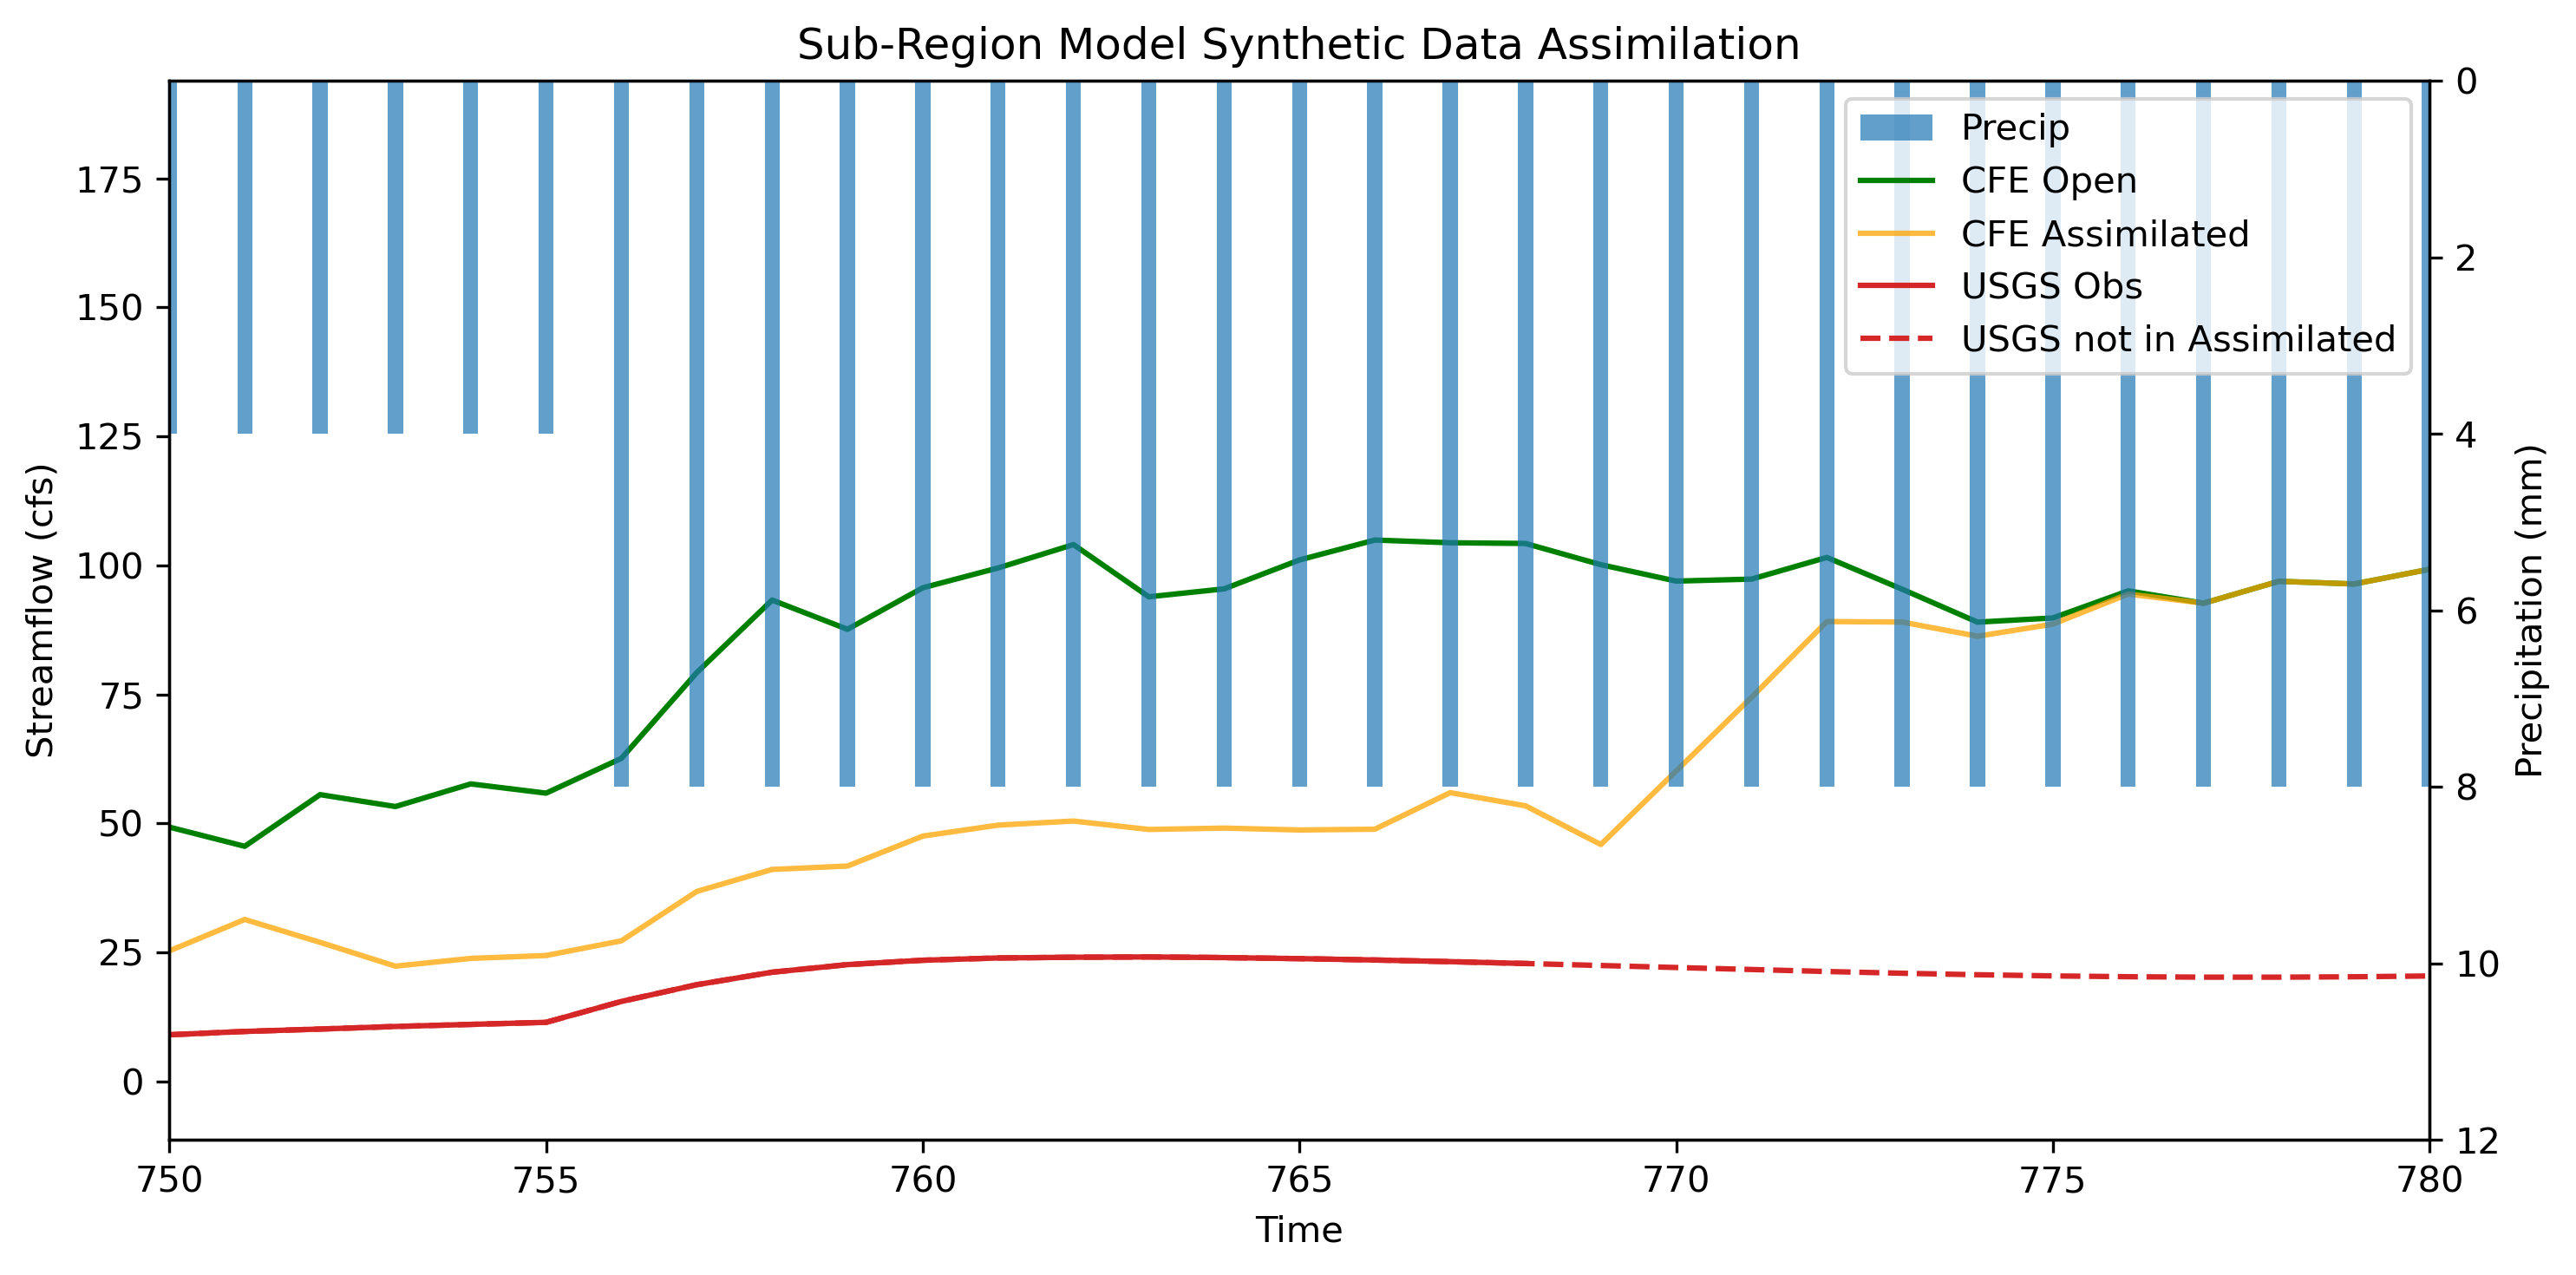

In [6]:
istart_plot=0
iend_plot=786
x = list(range(istart_plot, iend_plot))

Date_list = []
df_forcing['time'] = pd.to_datetime(df_forcing['time'], infer_datetime_format=True) 

fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

ax2 = ax1.twinx()

ax1.set_xlabel('Time')
ax1.set_ylabel('Streamflow (cfs)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,12,1)
ax2.invert_yaxis()
#ax1.set_ylim(0,50,1)
plt.xlim(750,780)

plt.title('Sub-Region Model Synthetic Data Assimilation')
Precip = ax2.bar(x, df_forcing['APCP_surface_0'],width=0.2,alpha=0.7, color="tab:blue", label = 'Precip')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
Open, = ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
Analysis, = ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'orange', alpha=0.75, label = 'CFE Assimilated')
Obs, = ax1.plot(OBSERVATIONS_LIST[istart_plot:769], color = 'tab:red', label = 'USGS Obs')
Obs2, = ax1.plot(OBSERVATIONS_LIST[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed', label = 'USGS not in Assimilated')
#ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')

#ax1.set_xlim([date(2017, 5, 15), date(2017, 6, 15)]) ## Customize date range for all plots
#ax1.tick_params(axis='x', labelrotation = 45)

plt.legend(handles = [Precip,Open,Analysis,Obs,Obs2], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))

#plt.savefig("WorkingDA_7-19.png")
fig.tight_layout()
ax1.margins(x=0)

plt.show()


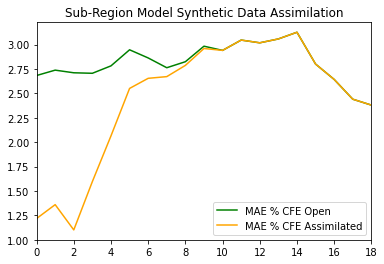

In [7]:
CFE_open=cfeOpen_ensa_mean[767:]
CFE_analysis=cfeanalys_ensa_mean[767:]

plt.title('Sub-Region Model Synthetic Data Assimilation')
plt.plot(CFE_open, color = 'green', label = 'MAE % CFE Open')
plt.plot(CFE_analysis, color = 'orange', label = 'MAE % CFE Assimilated')
plt.xlim(0,18)
plt.legend()
plt.show()



In [8]:
df=pd.DataFrame({"obs":OBSERVATIONS_LIST,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
# CFE open eval
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("r_open=",r_open[0])
print("KGE_open=",kge_open[0])
print("NSE_open=", nse_open[0])
print("PBias=", pbias[0])

# CFE Analysis
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("r_analysis=",r_analysis[0])
print("KGE_analysis=",kge_analysis[0])
print("NSE_analysis=", nse_analysis[0])
print("PBias=", pbias_analysis[0])

print("mean_obs=",np.mean(df["obs"]))
print("STD_obs=",np.std(df["obs"]))
print("mean_open=",np.mean(df["cfeOpen"]))
print("STD_open=",np.std(df["cfeOpen"]))
print("mean_analysis=",np.mean(df["cfeAnalysis"]))
print("STD_analysis=",np.std(df["cfeAnalysis"]))

r_open= 0.9752711532378185
KGE_open= -0.0767505289500583
NSE_open= -0.8777810226868932
PBias= 84.00853906632571
r_analysis= 0.9276081635408825
KGE_analysis= 0.18200315292878388
NSE_analysis= 0.21200944430888113
PBias= 65.88526847198892
mean_obs= 7.82998928152997
STD_obs= 11.330467618341043
mean_open= 48.96356445483878
STD_open= 34.65822995885161
mean_analysis= 22.951929945867796
STD_analysis= 21.762811275090137
